<a target="_blank" href="https://colab.research.google.com/github/aalonsopuig/RL_AAPGAG/blob/main/estudio_convergencia_q.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Convergencia de Q
Este estudio pretende mostrar que, ante una misma política y diferentes algoritmos, el retorno esperado (esto es Q) converge a un valor 
óptimo
Para mostrar este resultado se usará la evolución de la suma de la matriz Q conforme se generan episodios. Es de esperar que esta suma converja y sea la misma para dos agentes.

In [ ]:
!pip install gymnasium
!curl -O https://raw.githubusercontent.com/aalonsopuig/RL_AAPGAG/refs/heads/main/src/FrozenAgent.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25842  100 25842    0     0   102k      0 --:--:-- --:--:-- --:--:--  108k


In [3]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
import FrozenAgent
import random
import time

semilla=100

Cargamos el entorno

In [4]:


print("definimos el entorno:")
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.


definimos el entorno:


Función útil para establecer la semilla tanto en numpy como en la librería random

In [5]:

def setSemilla(semilla):
    random.seed(semilla)
    np.random.seed(semilla)


Algorimto genérico de para evaluar un agente

In [24]:

def train_agent(agent, env, num_episodes=5000, decay=False, semilla=1):
    #inicializamos el agente
    agent.initAgent()
    agent.sumQ=[]
    agent.sumQ.append(np.sum(agent.Q))
    for episode in tqdm(range(num_episodes)):
        state, info = env.reset(seed=semilla)
        done = False
    
        #inicializo el episodio
        agent.initEpisode()
    
        # play one episode
        while not done:
            if decay:
                agent.decay_epsilon()
            action = agent.get_action(env, state)
            
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.updateStep(state, action, reward, terminated, next_state)
            
            # update if the environment is done and the current state
            done = terminated or truncated
            state = next_state
            
        #después de acabar el episodio actualizo la Q y el epsilon
        agent.updateEpisode()
        #acumulamos la suma de Q por cada episodio
        agent.sumQ.append(np.sum(agent.Q))



Muestra los resultados recogidos por el agente durante su entrenamiento. Esta función muestra dos indicadores que implementan todos los agentes: 
* proporción de recompensas: suma recompensas / episodios
* proporción de tamaño de episodios: suma len(episodio) / episodios

In [21]:


def plot2(agent1,agent2,num):
  # Creamos una lista de índices para el eje x
  indices1 = list(range(len(agent1.list_stats)))
  indices2 = list(range(len(agent2.list_stats)))
    
  # Crear figura con dos subgráficos
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

  # Primer subplot
  ax1.plot(indices1[:num], agent1.list_stats[:num], label=agent1)
  ax1.plot(indices2[:num], agent2.list_stats[:num], label=agent2)
  ax1.set_title('Proporción de recompensas')
  ax1.set_xlabel('Episodio')
  ax1.set_ylabel('Proporción')
  ax1.legend()
  ax1.grid(True)

  # Segundo subplot
  ax2.plot(indices1[:num], agent1.sumQ[:num], label=agent1)
  ax2.plot(indices2[:num], agent2.sumQ[:num], label=agent2)
  ax2.set_title('Suma de Q')
  ax2.set_xlabel('Episodio')
  ax2.set_ylabel('Tamaño')
  ax2.legend()
  ax2.grid(True)

  # Primer subplot
  ax3.plot(indices1, agent1.list_stats, label=agent1)
  ax3.plot(indices2, agent2.list_stats, label=agent2)
  ax3.set_title('Proporción de recompensas')
  ax3.set_xlabel('Episodio')
  ax3.set_ylabel('Proporción')
  ax3.legend()
  ax3.grid(True)

  # Segundo subplot
  ax4.plot(indices1, agent1.sumQ, label=agent1)
  ax4.plot(indices2, agent2.sumQ, label=agent2)
  ax4.set_title('Suma de Q')
  ax4.set_xlabel('Episodio')
  ax4.set_ylabel('Tamaño')
  ax4.legend()
  ax4.grid(True)

  # Ajustar diseño y mostrar gráfico
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()  



Definimos dos agentes: Monte Carlo On Policy All Visits y Monte Carlo On Policy First visit.

Ejecutamos en entrenameiento y obtenemos la evolución de la suma de la matriz Q

In [ ]:


#inicializo los numeros aleatorios
setSemilla(semilla)

# hyperparameters
n_episodes = 50000
start_epsilon = 0.4
discount_factor = 0.99

agent1 = FrozenAgent.FrozenAgentMC_On_All(
    env=env4,
    epsilon=start_epsilon,
    discount_factor=discount_factor,
)
agent2 = FrozenAgent.FrozenAgentMC_On_First(
    env=env4,
    epsilon=start_epsilon,
    discount_factor=discount_factor,
)
setSemilla(semilla)
train_agent(agent1, env4, num_episodes=n_episodes, decay=False, semilla=semilla)
setSemilla(semilla)
train_agent(agent2, env4, num_episodes=n_episodes, decay=False, semilla=semilla)


100%|██████████| 50000/50000 [00:19<00:00, 2625.22it/s]


Mostramos resultados

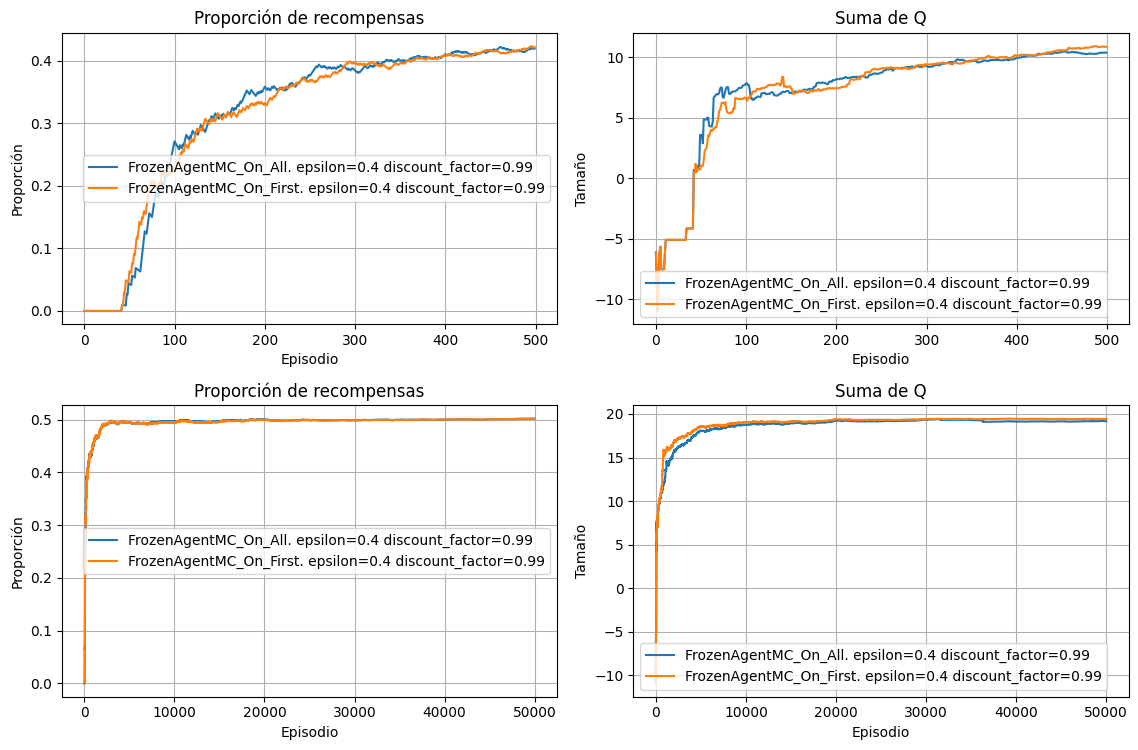

In [28]:
plot2(agent1,agent2,500)


La gráfica muestra pequeñas diferencias al principio pero al final convergen
El siguiente ejemplo se comprobará con el mapa de 8x8

In [30]:


#inicializo los numeros aleatorios
setSemilla(semilla)

# hyperparameters
n_episodes = 50000
start_epsilon = 0.4
discount_factor = 0.99

agent1 = FrozenAgent.FrozenAgentMC_On_All(
    env=env8,
    epsilon=start_epsilon,
    discount_factor=discount_factor,
)
agent2 = FrozenAgent.FrozenAgentMC_On_First(
    env=env8,
    epsilon=start_epsilon,
    discount_factor=discount_factor,
)
setSemilla(semilla)
train_agent(agent1, env8, num_episodes=n_episodes, decay=True, semilla=semilla)
setSemilla(semilla)
train_agent(agent2, env8, num_episodes=n_episodes, decay=True, semilla=semilla)


100%|██████████| 50000/50000 [00:40<00:00, 1221.21it/s]


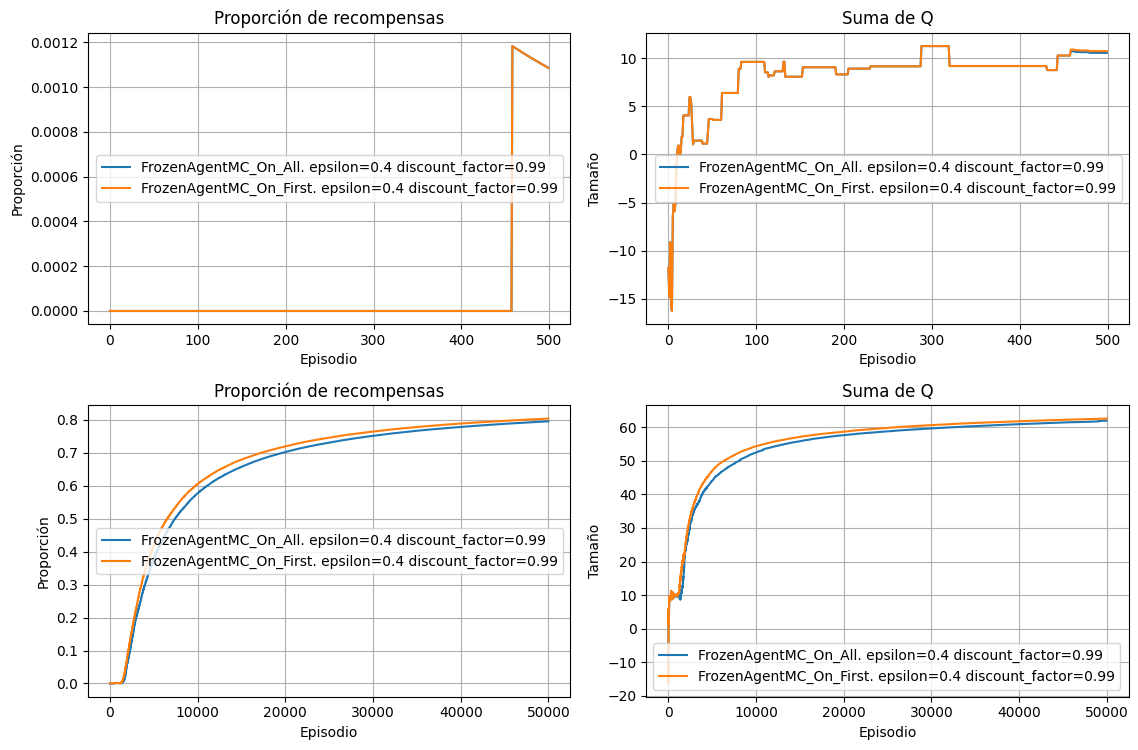

In [31]:
plot2(agent1,agent2,500)

Se observa que también en episodios más largos la suma de Q en ambos agentes convergen.